# Homework #6. Improve behaviour exploration
### Author: `Natalia Tomenko`
### Total time spent on h/w (in minutes): `350`

#### Importing data:

In [1]:
import pandas as pd

In [2]:
DIALOGS_MERGED_DATA_PATH = "../data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../data/merged_data/dialogs_users_all_edited.csv"

In [3]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH, low_memory=False, parse_dates = ['date'])
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

In [4]:
df['date'] = df['date'].dt.tz_convert('EET').dt.tz_localize(None)
df.set_index('id', inplace=True)

#### Separating personal messages from the rest and merging data

In [5]:
df_prsnl = df.loc[df['dialog_id'] > 0].copy()
df_prsnl.drop(df_prsnl.loc[df_prsnl['dialog_id'] == 1234060895].index, inplace=True)
df_prsnl.fillna(0, inplace=True)
df_prsnl.sort_values('date', inplace=True)
df_prsnl.reset_index(inplace=True)
df_prsnl = df_prsnl.join(df_meta.set_index('dialog_id')['name'], on='dialog_id')

df_prsnl_notime = df_prsnl.copy()
df_prsnl_notime['date'] = pd.to_datetime(df_prsnl_notime['date']).dt.normalize()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 
## Analysis
## 

&ensp; My goal for this homework was to analyze my interpersonal relatiоnships through Telegram private dialogs. More specifically, I selected top-10 people by the total number of messages since they are supposed to be the closest to me. So, the vast majority of questions in this analysis focuses on different aspects of those personal dialogs and in set to bring some clarity on how those dialogs differ. <br>&ensp; For the sake of anonimity (and because I usually save people in contacts with weird names), the names of top-10 people were replaced with... programming languages. So, here's the quick guide to who these people are so the analysis makes sense:

* friends from high school: C++, C# and Haskell
* my ex: Haskell
* my dad: Rust
* friend from another KMA faculty: PHP
* people from my major in KMA: Java, Python, Pascal, Kotlin, JavaScript 


#### 
#### 1. Sent and received personal messages: total and delta (sent - received)

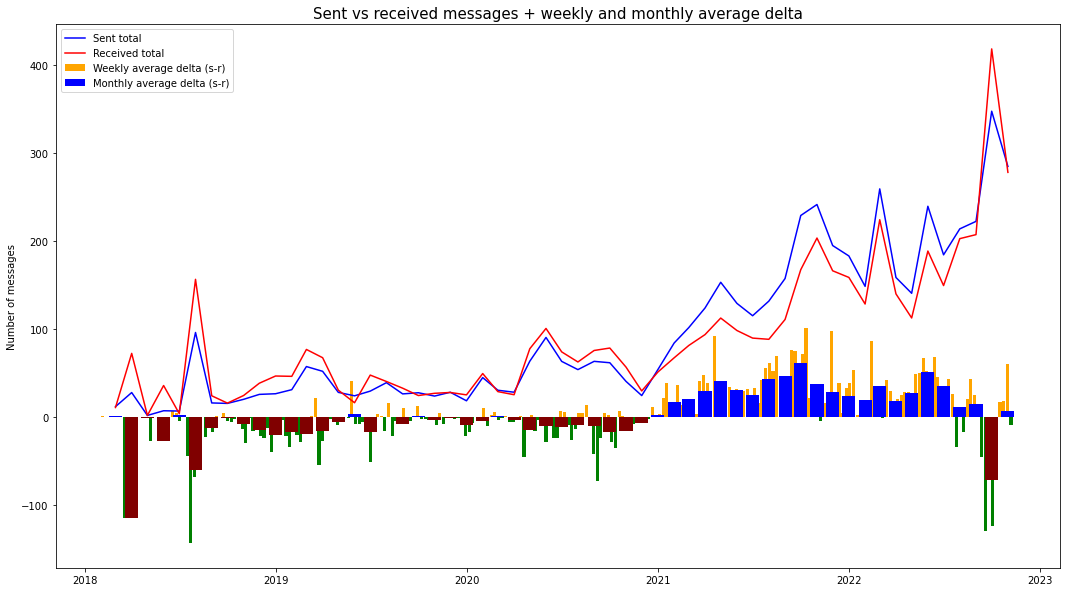

In [7]:
sent = df_prsnl_notime[df_prsnl_notime['from_id'] == 'PeerUser(user_id=511808031)'][["date", 
                                                                                "message"]].groupby('date').count()
received = df_prsnl_notime[df_prsnl_notime['to_id'] == '511808031'][["date", "message"]].groupby('date').count()
s = sent.resample('M').mean()
r = received.resample('M').mean()

delta = sent.copy()
delta['message'] = sent['message'] - received['message']
delta_w = delta.resample('W').mean()
delta_m = delta.resample('M').mean()

fig, axs = plt.subplots()
fig.set_size_inches(18, 10)
axs.plot(s.index, s['message'], 'blue')
axs.plot(r.index, r['message'], 'red')
axs.bar(delta_w.index, delta_w['message'], color=np.where(delta_w['message'] < 0, 'green', 'orange'), width=6)
axs.bar(delta_m.index, delta_m['message'], color=np.where(delta_m['message'] < 0, 'maroon', 'blue'), width=25)
plt.ylabel('Number of messages')

plt.legend(['Sent total', 'Received total', 'Weekly average delta (s-r)', 'Monthly average delta (s-r)'], 
           loc='upper left')
plt.title('Sent vs received messages + weekly and monthly average delta', size=15)
plt.show()

As we can see, up until the beginning of 2021 there were much more received messages, especially in the beginning of telegram messaging history. This is due me being friends with a very talkative person, who took up most of my messaging time. After that I changed my friend circle and moved to another city, therefore developing different messaging style which resulted in sent messages exceeding received. And the summer of 2022 was just a very weird period, so it differs from previous tendencies

#### 
#### 2. Top 10 dialogs by the total number of messages

In [8]:
df_top_10_people = df_prsnl[['message', 'name']].groupby('name').count().sort_values('message',
                                                                                            ascending=False).head(10)
df_top_10_people.reset_index(inplace=True)
df_top_10_people = df_top_10_people.join(df_meta.set_index('name')['dialog_id'], on='name')
df_top_10_people.rename(columns={'message': 'messages'}, inplace=True)

In [9]:
df_top_10_people

name  messages  dialog_id
0        C++      53599  666404127
1     Haskell     36637  472006716
2        Java     32734  257382115
3          C#     29427  548371427
4      Python     26955  346039675
5      Pascal     22632  336725046
6      Kotlin     14286  368111448
7        Rust      8603  319611979
8  JavaScript      7730  474680568
9         PHP      7538  494207796

Visualization in the next question))

#### 
#### 3. Sent and received messages for top-10 people 

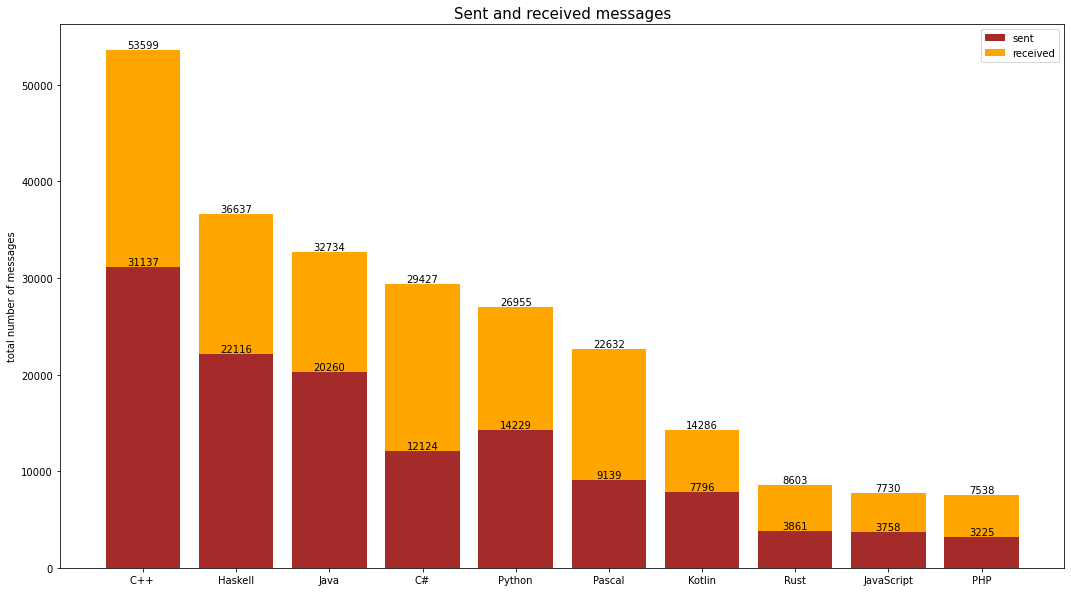

In [10]:
is_from_me = df_prsnl['from_id'] == 'PeerUser(user_id=511808031)'
is_to_me = df_prsnl['to_id'] == '511808031'

sent = [df_prsnl[(df_prsnl['name'] == x) & is_from_me].count()['message'] for x in df_top_10_people['name']]
received = [df_prsnl[(df_prsnl['name'] == x) & is_to_me].count()['message'] for x in df_top_10_people['name']]

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)

br = ax.bar(df_top_10_people['name'], sent, color='brown')
br2 = ax.bar(df_top_10_people['name'], received, bottom=sent, color='orange')
ax.bar_label(br)
ax.bar_label(br2)
plt.legend(['sent', 'received'])
plt.ylabel('total number of messages')


plt.title('Sent and received messages', size=15)
plt.show()

The first 2 people by total amount of messages are, unsurprisingly, C++ and Haskel - best friend of 4 years and my ex. People from who I've received much more messages than I've sent are the people who caused negative delta in 2018-2021 and in summer of 2022. Those are C# and Pascal. And the people who I sent more messages than received are Haskel and Java here to whom I talked mostly in 2021-2022 (positive delta in previous question)

#### 4. Sent/received comparison with message types included

In [11]:
def get_type(name, msg_type):
    filt = True
    if(msg_type == 's'):
        filt = df_prsnl['from_id'] == 'PeerUser(user_id=511808031)'
    if(msg_type == 'r'):
        filt = df_prsnl['to_id'] == '511808031'
        
    return df_prsnl.loc[(df_prsnl['name'] == name) & filt].groupby(["type"])["type"].count()

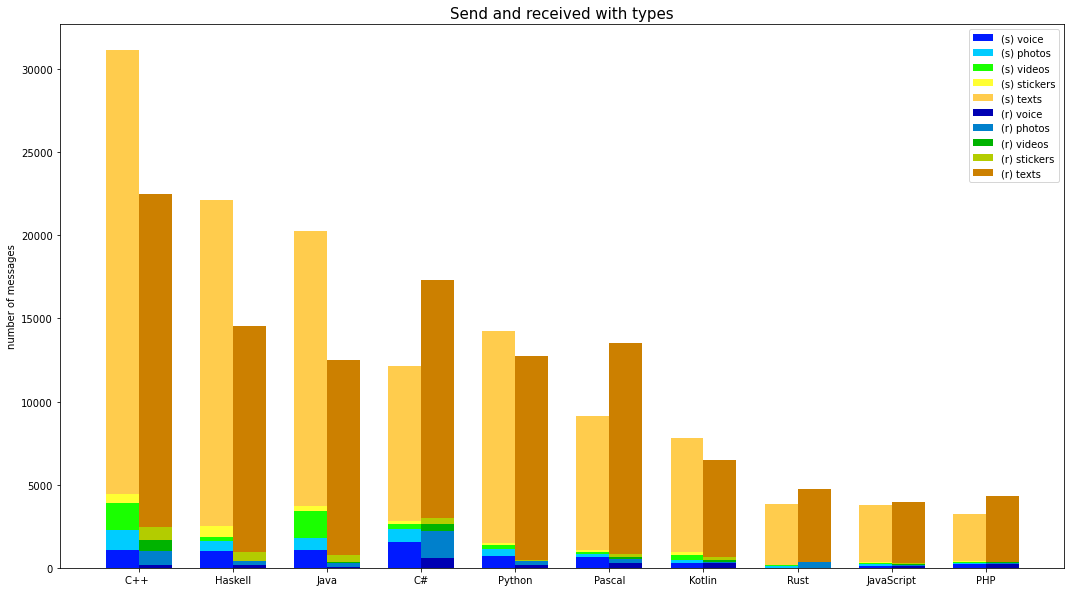

In [12]:
def plot_type(msg_type, barx, bottomm, i):
    if(msg_type == 's'):
        x_type = x - width/2
        color_type = colors_s[i]
    else:
        x_type = x + width / 2
        color_type = colors_r[i]
    ax.bar(x_type, barx, width, bottom=bottomm, color=color_type)
    bottomm += barx
    
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
labels = df_top_10_people['name']
x = np.arange(len(labels))
width = 0.35
colors_s = [(0, 0.8, 1), (1, 1, 0.2), (1, 0.8, 0.3), (0.1, 1, 0), (0, 0.1, 1)]
colors_r = [(0, 0.5, 0.8), (0.7, 0.8, 0), (0.8, 0.5, 0), (0, 0.7, 0), (0, 0, 0.7)]

bottomm = np.zeros(10)
for i in [4, 0, 3, 1, 2]:
    plot_type('s', [get_type(x, 's')[i] for x in df_top_10_people['name']], bottomm, i)

bottomm = np.zeros(10)
for i in [4, 0, 3, 1, 2]:
    plot_type('r', [get_type(x, 'r')[i] for x in df_top_10_people['name']], bottomm, i)
    
ax.set_xticks(x, labels)
plt.legend(["(s) voice", "(s) photos", '(s) videos', "(s) stickers", "(s) texts", "(r) voice", "(r) photos", 
            '(r) videos', "(r) stickers", "(r) texts"])
plt.title('Send and received with types', size=15)
plt.ylabel('number of messages')
plt.show()

The text to non-text messages ratio is mostly proportional with a few exceptions. And usually I'm the one who sends more voice and video messages (both in quantity and in %)

#### 5. % of types of total messages in each dialog

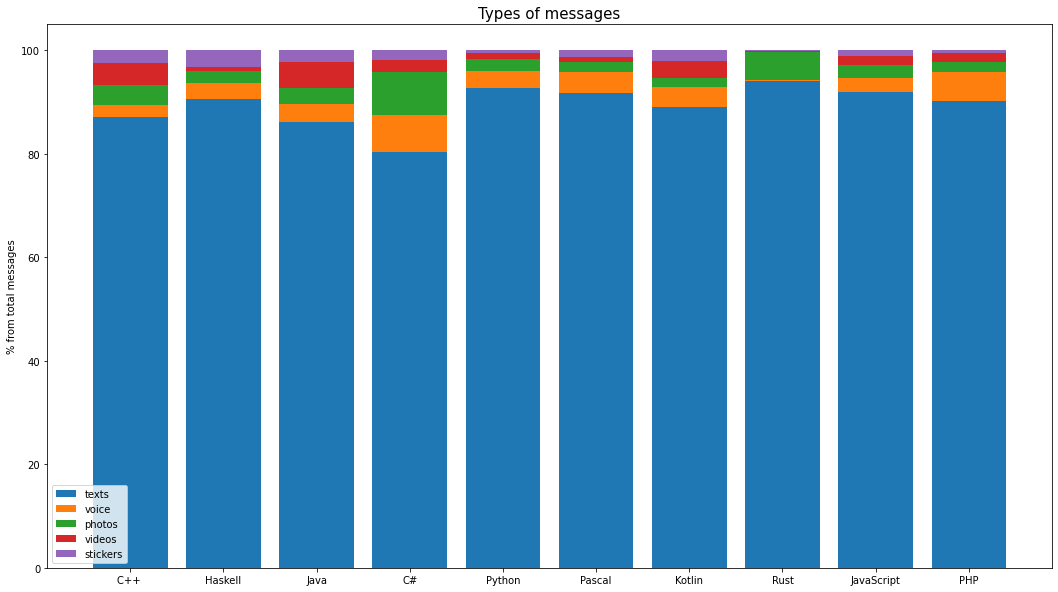

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
labels = df_top_10_people['name']
bar1 = [get_type(x, '-')[2] for x in df_top_10_people['name']] / df_top_10_people['messages'] * 100
bar2 = [get_type(x, '-')[4] for x in df_top_10_people['name']] / df_top_10_people['messages'] * 100
bar3 = [get_type(x, '-')[0] for x in df_top_10_people['name']] / df_top_10_people['messages'] * 100
bar4 = [get_type(x, '-')[3] for x in df_top_10_people['name']] / df_top_10_people['messages'] * 100
bar5 = [get_type(x, '-')[1] for x in df_top_10_people['name']] / df_top_10_people['messages'] * 100

ax.bar(labels, bar1)
ax.bar(labels, bar2, bottom=bar1)
ax.bar(labels, bar3, bottom=bar1+bar2)
ax.bar(labels, bar4, bottom=bar1+bar2+bar3)
ax.bar(labels, bar5, bottom=bar1+bar2+bar3+bar4)
plt.legend(["texts", "voice", "photos", 'videos', "stickers"])

plt.title('Types of messages', size=15)
plt.ylabel('% from total messages')
plt.show()

the most non-text messages I have with C# - my friend of 2018-2021, and the least with Rust - my dad (only photos of our cat and him cooking dinner)  :)

#### 
#### 6. The longest voice message for top-10 dialogs

In [14]:
def get_max_voice(df):
    return df[df["duration"] == df.loc[df["type"] == "voice"]["duration"].max()].iloc[0]['duration'].item() / 60

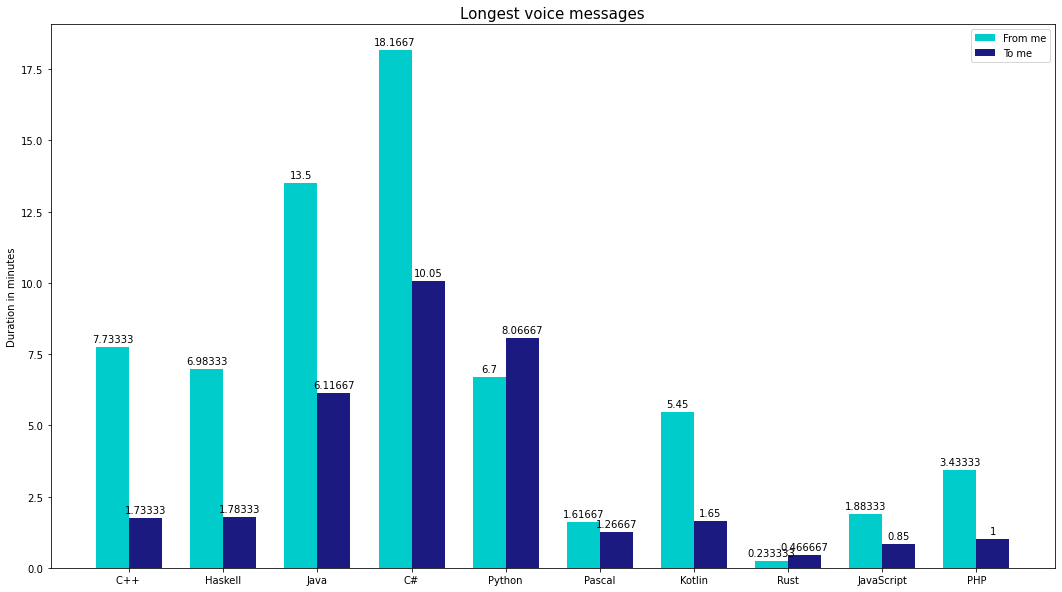

In [15]:
is_from_me = df_prsnl['from_id'] == 'PeerUser(user_id=511808031)'
is_to_me = df_prsnl['to_id'] == '511808031'

voice_from_me = [ get_max_voice(df_prsnl[(df_prsnl['name'] == x) & is_from_me]) for x in df_top_10_people['name']]
voice_to_me = [ get_max_voice(df_prsnl[(df_prsnl['name'] == x) & is_to_me]) for x in df_top_10_people['name']]

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
labels = df_top_10_people['name']
x = np.arange(len(labels))
width = 0.35

br1 = ax.bar(x - width/2, voice_from_me, width, label='From me', color = (0, 0.8, 0.8))
br2 = ax.bar(x + width/2, voice_to_me, width, label='To me', color = (0.1, 0.1, 0.5))
ax.set_xticks(x, labels)
ax.legend()
ax.bar_label(br1, padding=3)
ax.bar_label(br2, padding=3)

plt.title('Longest voice messages', size=15)
plt.ylabel('Duration in minutes')
plt.show()

Unsurprisingly, statistics are similar to the one for previous question. The person with whom I exchanged the most voice messaged has the longest one, and the person with whom I have the least voice messages has the shortest one. Also, this chart shows that I generally like sending voice messages

#### 
#### 7. Number of messages a day with top 10 people </span>

In [16]:
def get_messages(name):
    filt = df_prsnl_notime['name'] == name
    return df_prsnl_notime[filt][['date','message']].groupby('date').count().resample('W').mean()

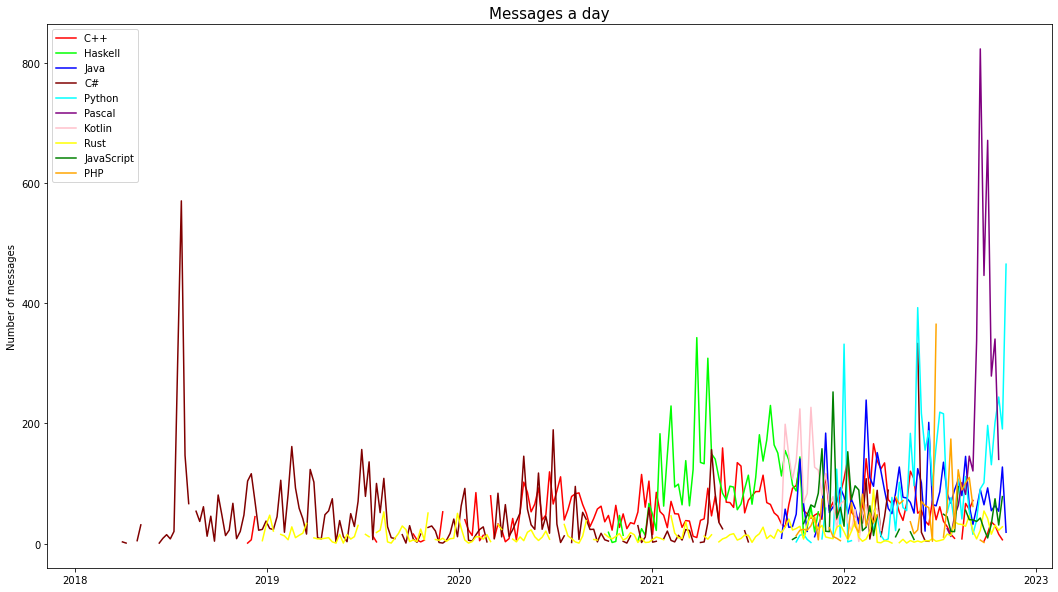

In [17]:
fig, axs = plt.subplots()
fig.set_size_inches(18, 10)
df_top_10_people['color'] = ['red', 'lime','blue',  'maroon', 'cyan', 'purple', 'pink', 'yellow', 'green', 'orange']

for x in range(0, 10):
    person = get_messages(df_top_10_people.loc[x,'name'])
    axs.plot(person.index, person['message'], color=df_top_10_people.loc[x, 'color'])
    axs.legend(df_top_10_people['name'])


plt.title('Messages a day', size=15)
plt.ylabel('Number of messages')
plt.show()

This chart has 2 main spikes. First one, C# in the beginning, when I just started using telegram, and the second huge spike in Pascal in the summer of 2022. Also, even though I expected to see a lot of messages with the last person, I was very surprised to see this much.And if we're lookong at plots for particular people, the most from the rest differs the one for my dad (Rust). The rest of it, excluding Pascal, have a pretty similar pattern

#### 8. Messages from top-10 people for each 6 months

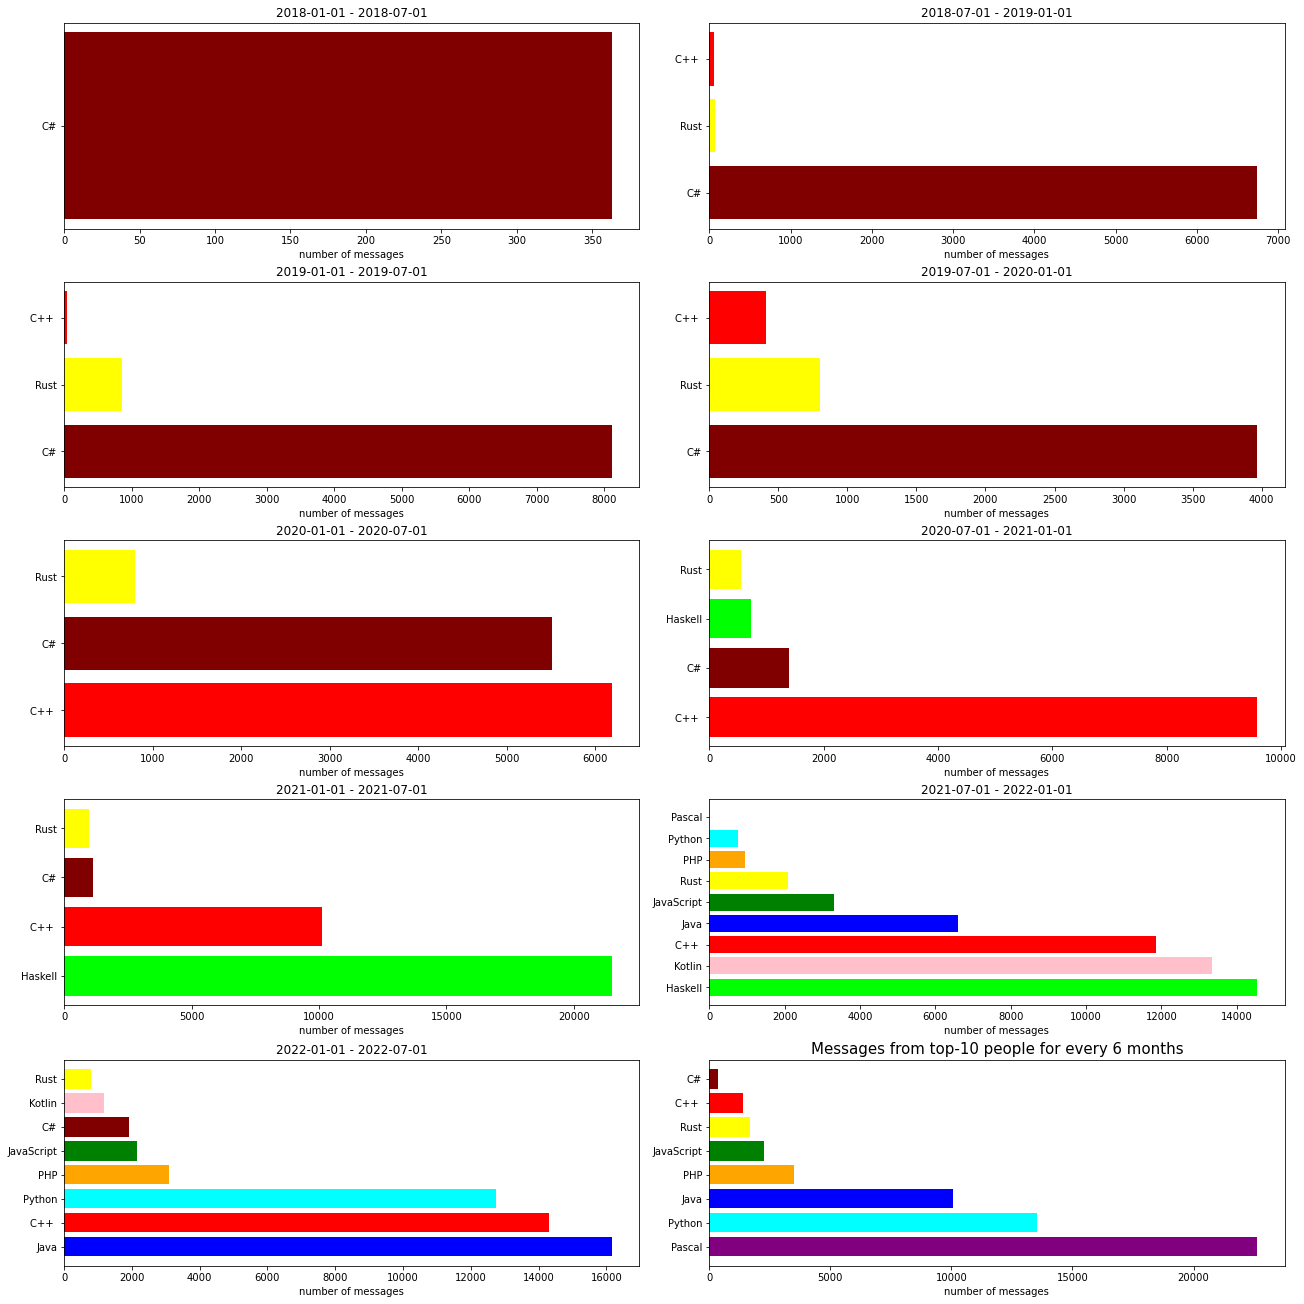

In [18]:
df_prsnl['top_10_person'] = df_prsnl['dialog_id'].isin(df_top_10_people['dialog_id'])
columns = ['date', 'from_id', 'to_id', 'message', 'type', 'dialog_id']
df_top_10_full = df_prsnl[df_prsnl['top_10_person'] == True][columns]
df_top_10_full = df_top_10_full.join(df_meta.set_index('dialog_id')['name'], on='dialog_id')
time_marks=['2018-01-01', '2018-07-01', '2019-01-01', '2019-07-01', '2020-01-01', '2020-07-01', 
            '2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01', '2023-10-31']

def get_period(from_date, to_date):
    df = df_top_10_full.set_index('date').loc[from_date:to_date].groupby('name').count().sort_values('message', 
                                                                                                    ascending=False)
    return df.join(df_top_10_people.set_index('name')['color'], on='name')

fig, axs = plt.subplots(5, 2, constrained_layout = True)
fig.set_size_inches(18, 18)
counter=0

for i in range(0, 5):
    for j in range(0, 2):
        period = get_period(time_marks[counter], time_marks[counter+1])
        axs[i, j].barh(period.index, period['message'], color=period['color'])
        axs[i, j].set_title(time_marks[counter] +' - ' + time_marks[counter+1])
        axs[i, j].set_xlabel('number of messages')
        counter += 1

plt.title('Messages from top-10 people for every 6 months', size=15)
plt.show()

Periods with the most messages were the beginning of 2021 and the second half of 2022

#### 
#### 9. Difference in sent and received messages for top-10 people 

In [19]:
def get_delta(name):
    filt = df_prsnl_notime['name'] == name
    is_from_me = df_prsnl_notime['from_id'] == 'PeerUser(user_id=511808031)'
    is_to_me = df_prsnl_notime['to_id'] == '511808031'
    
    sent = df_prsnl_notime[filt & is_from_me][['date', 'message']].groupby('date').count().resample('W').mean()
    received = df_prsnl_notime[filt & is_to_me][['date', 'message']].groupby('date').count().resample('W').mean()
    sent['delta'] = sent['message'] - received['message']
    
    return sent

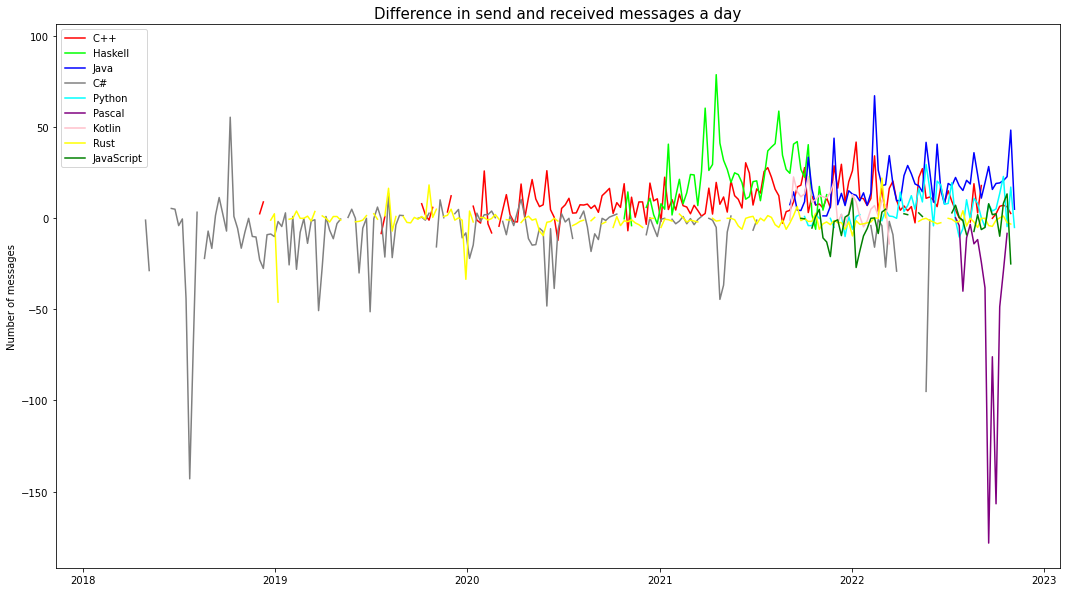

In [20]:
fig, axs = plt.subplots()
fig.set_size_inches(18, 10)
colors = ['red', 'lime','blue',  'grey', 'cyan', 'purple', 'pink', 'yellow', 'green', 'orange']

for x in range(0, 9):
    person = get_delta(df_top_10_people.loc[x,'name'])
    axs.plot(person.index, person['delta'], color=colors[x])
    axs.legend(df_top_10_people['name'])
    
plt.title('Difference in send and received messages a day', size=15)
plt.ylabel('Number of messages')
plt.show()

Same two spikes, this time negative, which shows that I wasn't the one mainly causing them in the previous plot

#### 
#### //creating a dataframe for everyday stats//

In [21]:
def get_grouped_df(date):
    return df_prsnl_notime.loc[df_prsnl_notime['date'] == date].groupby('dialog_id').count().sort_values('message',
                                                                                    ascending=False).reset_index()
def get_top_10(date):
    df = get_grouped_df(date)
    not_top_10 = df[~df['dialog_id'].isin(df_top_10_people['dialog_id'])].index
    return df.drop(not_top_10)

df_daily = df_prsnl_notime[['date','message']].groupby('date').count()

df_daily['from_top_10'] = [get_top_10(x)['message'].sum() for x in df_daily.index]
df_daily['from_#1'] = [get_grouped_df(x).loc[0, 'message'] for x in df_daily.index]
df_daily['#1_person_id'] = [get_grouped_df(x).loc[0, 'dialog_id'] for x in df_daily.index]

df_daily = df_daily.join(df_meta.set_index('dialog_id')['name'], on='#1_person_id')
df_daily.rename(columns={'message': 'total_messages', 'name': '#1_person_name'}, inplace=True)

#### 
#### 10. Daily total messages vs to top 10 people vs to top 1 person

Clarification: top 10 people are the ones with the most total messages (mentioned above), and #1 person is dialog with who has the most messages for that particular day

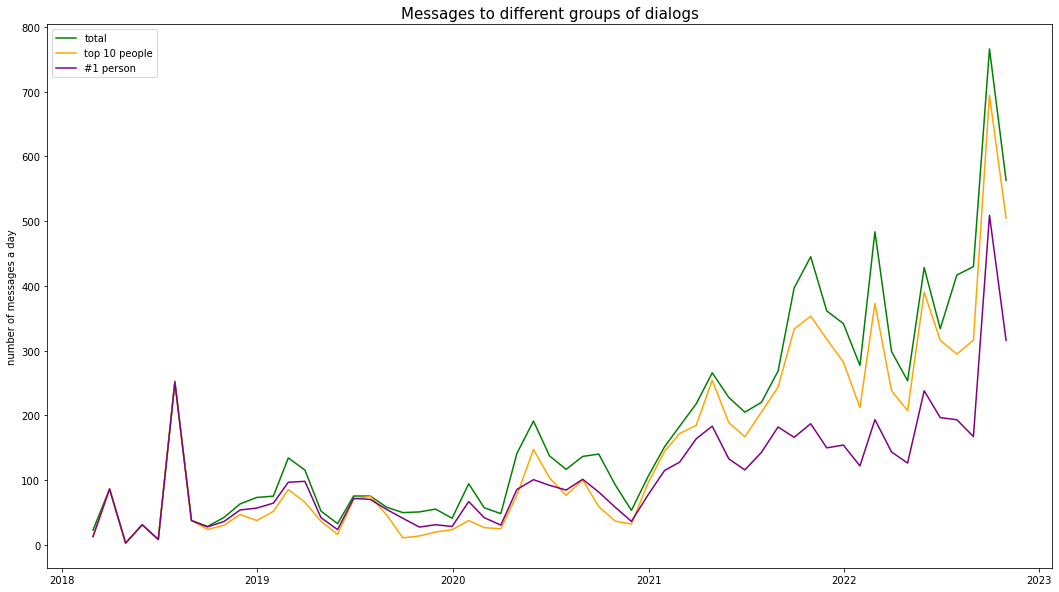

In [22]:
df_monthly = df_daily[['total_messages', 'from_top_10', 'from_#1']].resample('M').mean()

fig, axs = plt.subplots()
fig.set_size_inches(18, 10)
axs.plot(df_monthly.index, df_monthly['total_messages'], 'green')
axs.plot(df_monthly.index, df_monthly['from_top_10'], 'orange')
axs.plot(df_monthly.index, df_monthly['from_#1'], 'purple')
plt.legend(['total', 'top 10 people', '#1 person'])
plt.ylabel('number of messages a day')
plt.title('Messages to different groups of dialogs', size=15)
plt.show()

Those 2 spikes are already becoming obvious, but what's interesting is the period from the beginning of 2021 to summer of 2022. Big distance between lines means that the person I talk to most starts taking taking up less % of my texting time. Therefore, we can say that conclusiong in the first chart about positive delta was somewhat incorrect and the reason was not changing messaging habits, but talking to more new (and different) people.

#### 
#### 11. periods of talking with top 10 people

In [23]:
def get_dates(name):
    return df_prsnl_notime[df_prsnl_notime['name'] == name]['date']

def get_top_dates(name):
    return df_daily[df_daily['#1_person_name'] == name].index

df_top_10_people['first_day_talking'] = [min(get_dates(x)) for x in df_top_10_people['name']]
df_top_10_people['first_#1_day'] = [min(get_top_dates(x)) for x in df_top_10_people['name']]
df_top_10_people['last_day_talking'] = [max(get_dates(x)) for x in df_top_10_people['name']]
df_top_10_people['last_#1_day'] = [max(get_top_dates(x)) for x in df_top_10_people['name']]

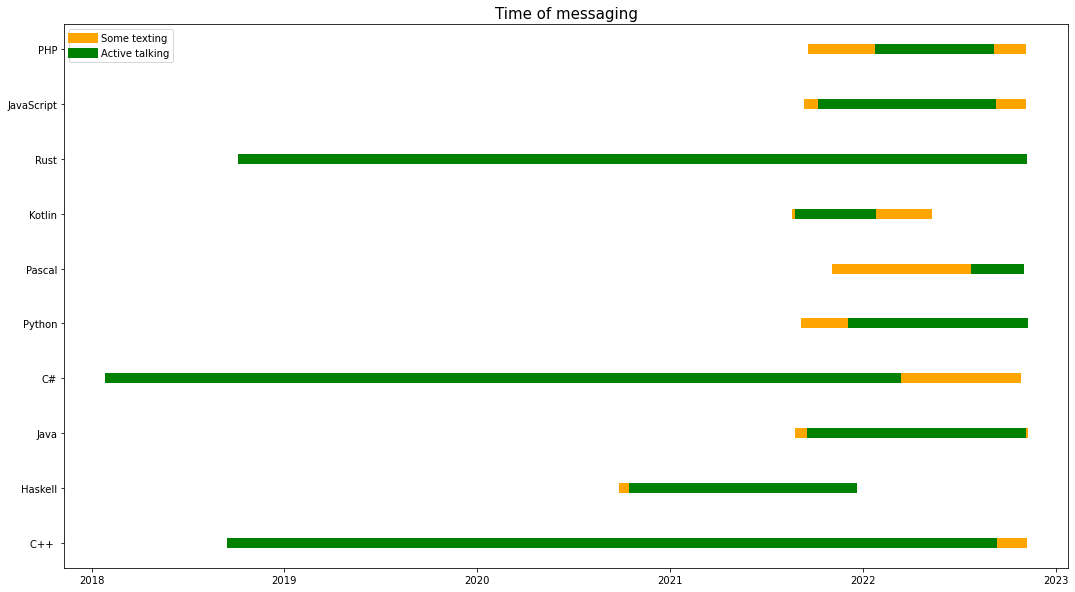

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
for i in range (0, 10):
    x1 = [df_top_10_people.loc[i, 'first_day_talking'], df_top_10_people.loc[i, 'last_day_talking']]
    x2 = [df_top_10_people.loc[i, 'first_#1_day'], df_top_10_people.loc[i, 'last_#1_day']]
    ax.plot(x1, [i+1, i+1], 'orange', linewidth=10, label='Some texting')
    ax.plot(x2, [i+1, i+1], 'green', linewidth=10, label='Active talking')
    if(i == 0):
        ax.legend(loc='upper left')   

plt.title('Time of messaging', size=15)
plt.yticks(np.arange(1, 11), labels=df_top_10_people['name'])
plt.show()

As can be seen, most of people that are top-10 in total messages I've met in 2021. This proves the previous conclusion about me significantly increasing (or rapidly changing) friend circle in that time.

#### 
#### 12. Number of days top-10 people were #1 in a number of messages

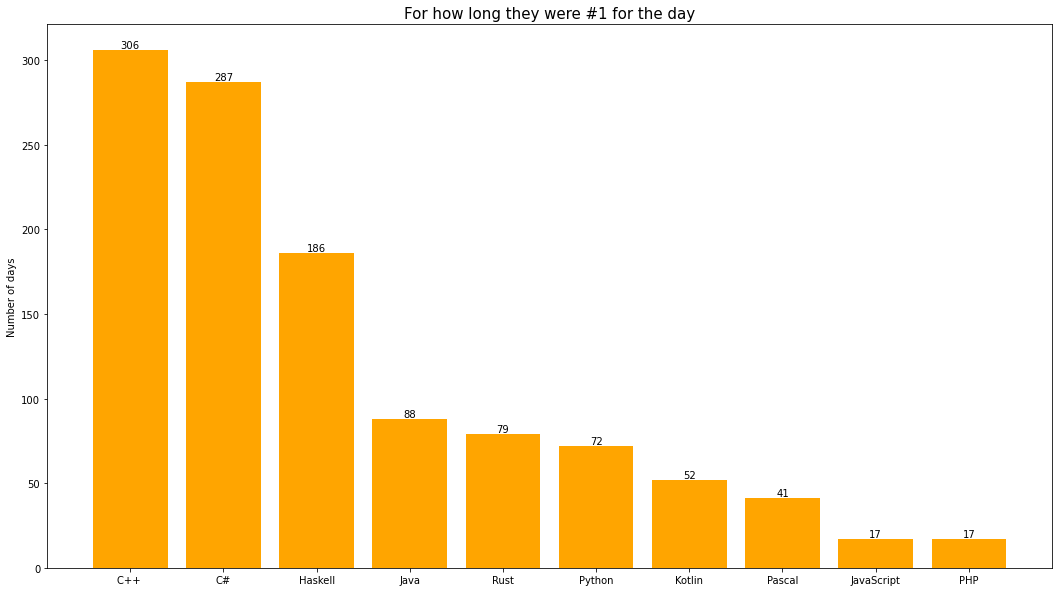

In [25]:
df_top_10_people['days_#1'] = [df_daily.loc[df_daily['#1_person_name'] == x]['total_messages'].count() for x in 
                               df_top_10_people['name']]

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
br = ax.bar(np.arange(10), df_top_10_people.sort_values('days_#1', ascending=False)['days_#1'], color='orange')
ax.set_xticks(np.arange(10), labels=df_top_10_people.sort_values('days_#1', ascending=False)['name'])
ax.bar_label(br)
plt.ylabel("Number of days")

plt.title('For how long they were #1 for the day', size=15)
plt.show()

Top3 are the people who I've met the earliest out of all (excluding my dad), which is confirmed by the previous chart

#### 
#### 13. People that are not in top-10 by total messages, but were #1 on some days

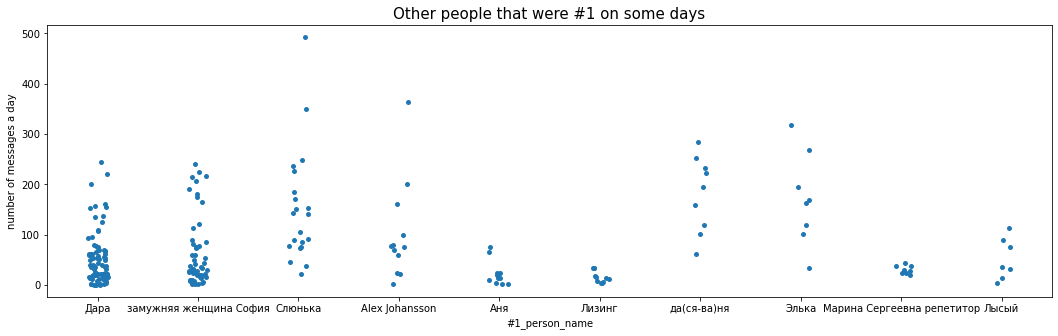

In [26]:
not_top_10 = df_daily.loc[~df_daily['#1_person_name'].isin(set(df_top_10_people['name']))]
not_t10 = not_top_10.groupby('#1_person_name').count().sort_values('from_#1', ascending=False).head(10).index

fig, axs = plt.subplots()
fig.set_size_inches(18, 5)
sns.stripplot(data=not_top_10.set_index('#1_person_name').loc[not_t10], x='#1_person_name', y="from_#1")
plt.ylabel('number of messages a day')
plt.title('Other people that were #1 on some days', size=15)
plt.show()

Those are either people from my friendgroups who I didn't talk much with or my classmates or other studying-related connections

#### 
#### 14.Average messaging stats

Here I calculated max messages a day, average for the days that person #1, and average a day for all the time we were messaging

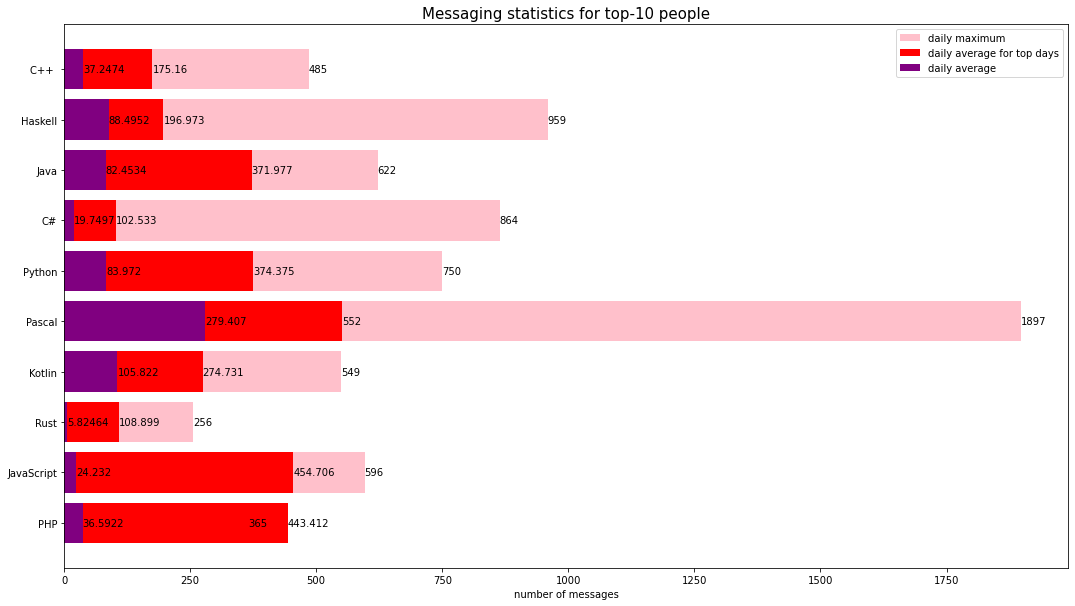

In [27]:
df_top_10_people['max_daily'] = [df_daily[df_daily['#1_person_name'] == x].sort_values('from_#1', ascending=False).
                                 reset_index().loc[0, 'from_#1'] for x in df_top_10_people['name']]

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)

#max messages a day
br1 = ax.barh(np.arange(10), df_top_10_people['max_daily'], color='pink')
#average messages for the day they were #1
br2 = ax.barh(np.arange(10), (df_top_10_people['messages'] / df_top_10_people['days_#1']), color='red')
#average messages a day throughout acting talking period
br3 = ax.barh(np.arange(10), (df_top_10_people['messages'] / (df_top_10_people['last_#1_day'] -
                                                        df_top_10_people['first_#1_day']).dt.days), color='purple')

ax.set_yticks(np.arange(10), labels=df_top_10_people['name'])
ax.invert_yaxis()
ax.bar_label(br1)
ax.bar_label(br2)
ax.bar_label(br3)
plt.xlabel('number of messages')
plt.title('Messaging statistics for top-10 people', size=15)
plt.legend(['daily maximum', 'daily average for top days', 'daily average'])

plt.show()

#### 
#### Modifying original messages dataset to show only top-10 people

In [28]:
df_top_10_full.sort_values(['dialog_id', 'date'], inplace=True)
df_top_10_full.reset_index(inplace=True)
df_top_10_full.drop(columns=['index'], inplace=True)

dialogs_order = df_top_10_people['dialog_id'].tolist()
dialogs_order.sort()

#### 15. Average time between messages in dialogs

In [29]:
def calc_delta(is_from_me, last_from_me):
    is_from_me = (df_top_10_full.loc[i, 'from_id'] == 'PeerUser(user_id=511808031)')
    time_after = (df_top_10_full.loc[i, 'date'] - df_top_10_full.loc[(i-1), 'date']).total_seconds() / 60
    return time_after if (last_from_me != is_from_me) else None

In [30]:
time_after_last = []
counter = 0;
last_from_me = True

for x in dialogs_order:
    time_after_last.append(None)
    messages = df_top_10_people.loc[df_top_10_people['dialog_id'] == x]['messages'].item()
    for i in range((counter + 1),(counter + messages)):
        is_from_me = (df_top_10_full.loc[i, 'from_id'] == 'PeerUser(user_id=511808031)')
        time_after_last.append(calc_delta(is_from_me, last_from_me))
        last_from_me = is_from_me
    counter += messages

df_top_10_full['time_after_last'] = time_after_last

In [31]:
from_me = df_top_10_full.loc[df_top_10_full['from_id'] == 'PeerUser(user_id=511808031)']
to_me = df_top_10_full.loc[df_top_10_full['to_id'] == '511808031']

print('from me: after', from_me['time_after_last'].mean(), 'minutes')
print('to me: after', to_me['time_after_last'].mean(), 'minutes')

from me: after 47.74492506732488 minutes
to me: after 55.10815932280909 minutes


Therefore, I either reply faster or text more than most people I talk to.

#### 
#### 16. Who usually texts first in top-10 dialogs

As texting first here I consider messages that are more than 10 hours apart from the last one, and the privious message doesn't contain a question

In [32]:
def get_first_texter(df, dialog_id, gap):
    #the person who texts first is the person who receives less first texts -> 'to_id' count is less
    return df.loc[(df['dialog_id'] == dialog_id) & (df['time_after_last'] > gap)][['to_id','time_after_last'
                            ]].groupby('to_id').count().sort_values('time_after_last').reset_index().loc[0, 'to_id']

questions_index = df_top_10_full[df_top_10_full['message'].str.contains("\?") ==  True].index
no_answers = df_top_10_full.drop(questions_index + 1)
texts_first_most = [get_first_texter(no_answers, x, 600) for x in df_top_10_people['dialog_id']]

for i in range(0,9):
    print(df_top_10_people.loc[i, 'name'], ': ', 'them' if (int(texts_first_most[i]) == 
                                                      df_top_10_people['dialog_id'].iloc[i]) else 'me')

C++  :  me
Haskell :  me
Java :  me
C# :  me
Python :  me
Pascal :  them
Kotlin :  me
Rust :  them
JavaScript :  me


#### 
#### 17. Average reply time for top-10 people 

As a reply here I consider any message that comes after the one with question mark from another user. All questions that took more than 24h to respond to are considered ignored due to high rates of it really being so)

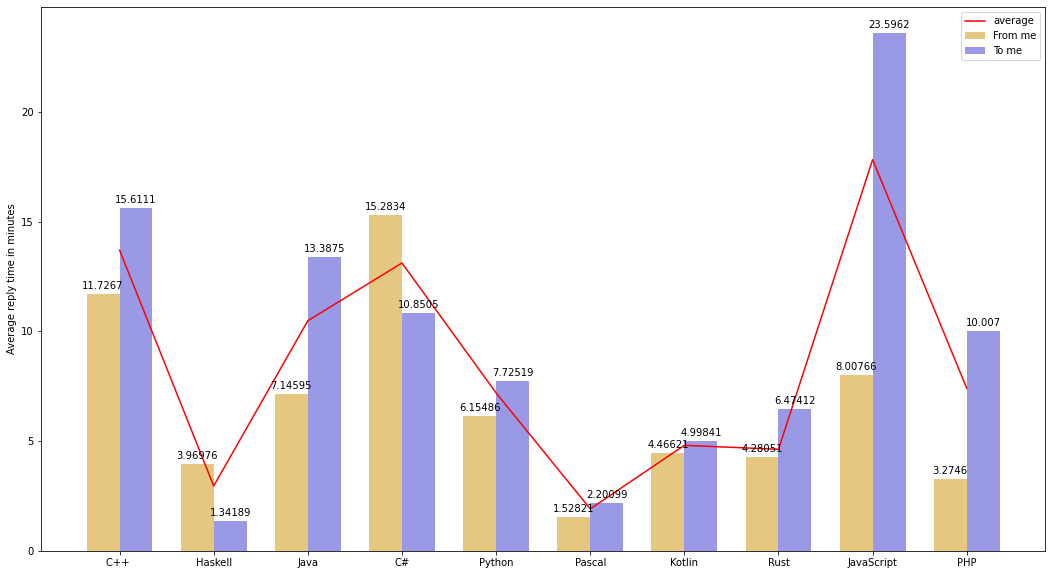

In [33]:
df_replies = df_top_10_full.loc[questions_index+1].loc[df_top_10_full['time_after_last'] < 60*24]
is_from_me = df_top_10_full['from_id'] == 'PeerUser(user_id=511808031)'
is_to_me = df_top_10_full['to_id'] == '511808031'

average_from_me = [df_replies.loc[(df_replies['dialog_id'] == x) & is_from_me]['time_after_last'
                                                                ].mean() for x in df_top_10_people['dialog_id']]
average_to_me = [df_replies.loc[(df_replies['dialog_id'] == x) & is_to_me]['time_after_last'
                                                                ].mean() for x in df_top_10_people['dialog_id']]
average = [df_replies.loc[df_replies['dialog_id'] == x]['time_after_last'].mean() for x in 
           df_top_10_people['dialog_id']]

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
labels = df_top_10_people['name']
x = np.arange(len(labels))
width = 0.35

br1 = ax.bar(x - width/2, average_from_me, width, label='From me', color = [0.9, 0.78, 0.5])
br2 = ax.bar(x + width/2, average_to_me, width, label='To me', color = [0.6, 0.6, 0.9])
ax.set_xticks(x, labels)
ax.plot(x, average, 'red', label='average')
ax.legend()
ax.bar_label(br1, padding=3)
ax.bar_label(br2, padding=3)

plt.ylabel('Average reply time in minutes')
plt.show()

The longer takes to reply JavaScript, which is not surprising since he's always busy with work. And the shortest reply time I have from Haskell and Pascal. And also, almost for all these people the statistics is that I reply faster than receive one. Combining results from this question and the previous two I can say that I both text more and reply faster

#### 
#### 18. Average reply time to any message depending on what time gap is considered beginning of the new discussion

In general, replies are not only messages that come after questions. When texting, any message sent in response to another user's message can be considered a reply. But in this case there's a risk of counting a beginning of a new dialog as a long reply to previous. So, in this question I wanted to see average reply time based on how much gap time is considered to be the new dialog.

In [34]:
def average_to_me(max_gap):
    return [df_top_10_full.loc[(df_top_10_full['dialog_id'] == x) & is_to_me & (df_top_10_full
                    ['time_after_last'] < max_gap)]['time_after_last'].mean() for x in df_top_10_people['dialog_id']]

def average_from_me(max_gap):
    return [df_top_10_full.loc[(df_top_10_full['dialog_id'] == x)& is_from_me & (df_top_10_full
                    ['time_after_last'] < max_gap)]['time_after_last'].mean() for x in df_top_10_people['dialog_id']]

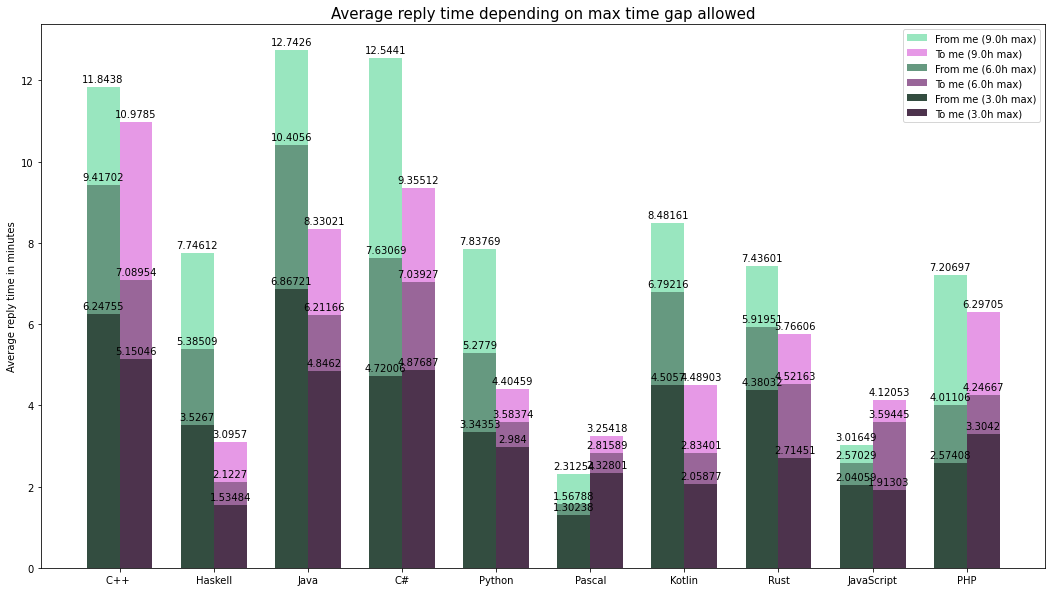

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
labels = df_top_10_people['name']
x = np.arange(len(labels))
width = 0.35

for i in range(540, 179, -180):
    br1 = ax.bar(x - width/2, average_from_me(i), width, label='From me ({}h max)'.format(i/60), 
                 color=[(0.2*i/180, 0.3*i/180, 0.25*i/180)])
    br2 = ax.bar(x + width/2, average_to_me(i), width, label='To me ({}h max)'.format(i/60), 
                 color=[(0.3*i/180, 0.2*i/180, 0.3*i/180)])
    ax.set_xticks(x, labels)
    ax.legend()
    ax.bar_label(br1, padding=3)
    ax.bar_label(br2, padding=3)
    
plt.ylabel('Average reply time in minutes')
plt.title('Average reply time depending on max time gap allowed', size=15)
plt.show()

Statistics are different from previous because here long replies are not accounted for

#### 
#### 19. Total activity in personal chats throughout the day

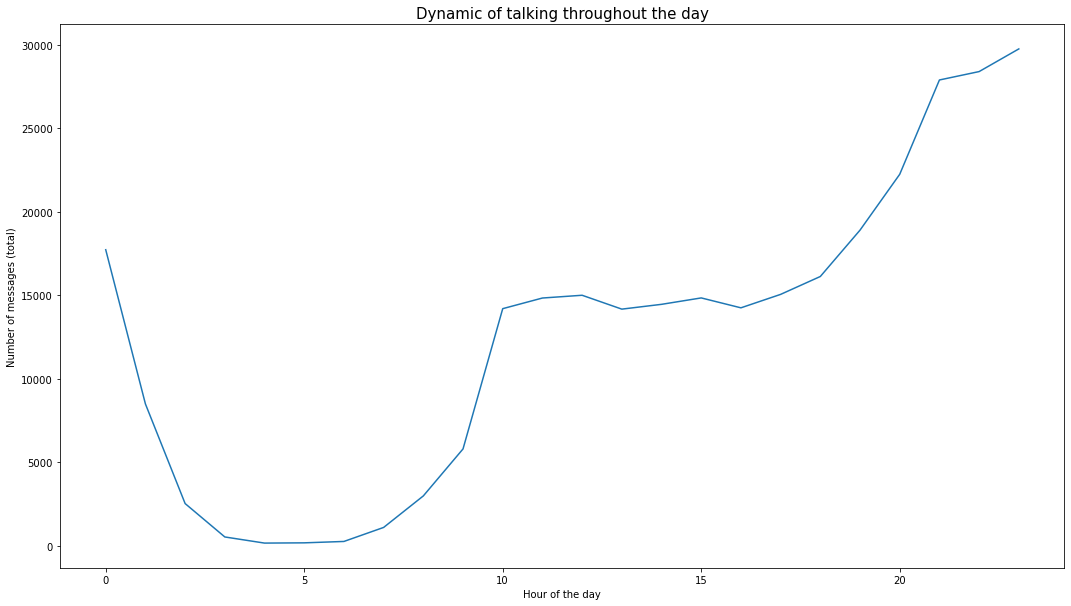

In [36]:
time_grp_1 = df_prsnl[['date','message']].groupby('date').count().resample('H').sum().reset_index()
time_grp_1['time'] = time_grp_1['date'].dt.time
time_grp_2 = time_grp_1[['message', 'time']].groupby('time').sum().reset_index()
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
ax.plot(np.arange(0, 24), time_grp_2['message'])
plt.ylabel('Number of messages (total)')
plt.xlabel('Hour of the day')
plt.title('Dynamic of talking throughout the day', size=15)
plt.show()

According to this plot I am very active in telegram in the evening after ~17:00, and the most active at night after ~22:00

#### 20.% of messages for 4-hour periods of the day

[]

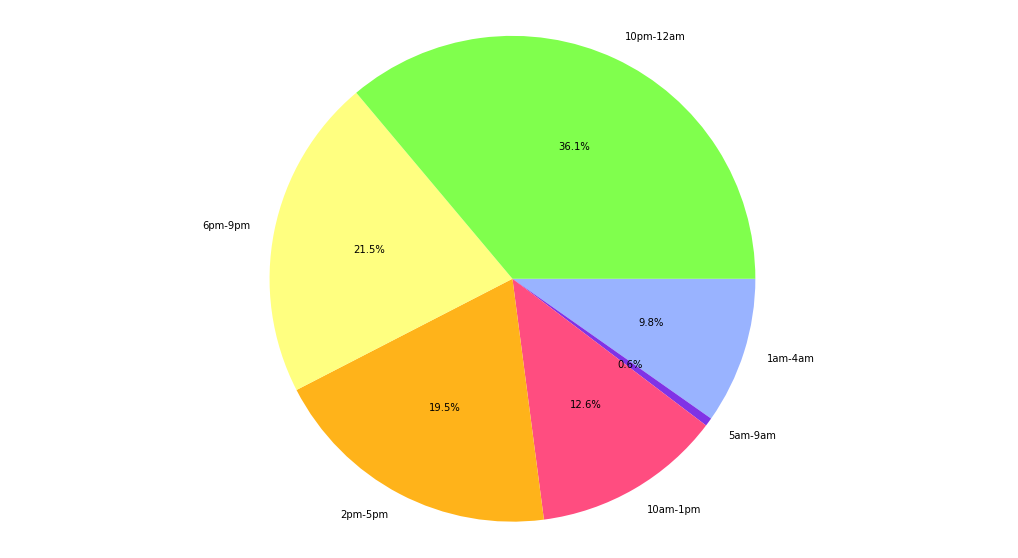

In [37]:
time_grp_1 = df_prsnl[['date','message']].groupby('date').count().resample('4H').sum().reset_index()
time_grp_1['time'] = time_grp_1['date'].dt.time
time_grp_2 = time_grp_1[['message', 'time']].groupby('time').sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
labels=['1am-4am', '5am-9am', '10am-1pm', '2pm-5pm', '6pm-9pm', '10pm-12am']
ax.pie(time_grp_2['message'], labels=labels, autopct='%1.1f%%', counterclock=False, colors=[(0.6, 0.7, 1), 
                                    (0.5, 0.2, 0.9), (1, 0.3, 0.5), (1, 0.7, 0.1), (1, 1, 0.5),(0.5, 1, 0.3)])
ax.axis('equal')
plt.plot()

#### 
#### 21. At what time of the day I talk(talked) the most to different people

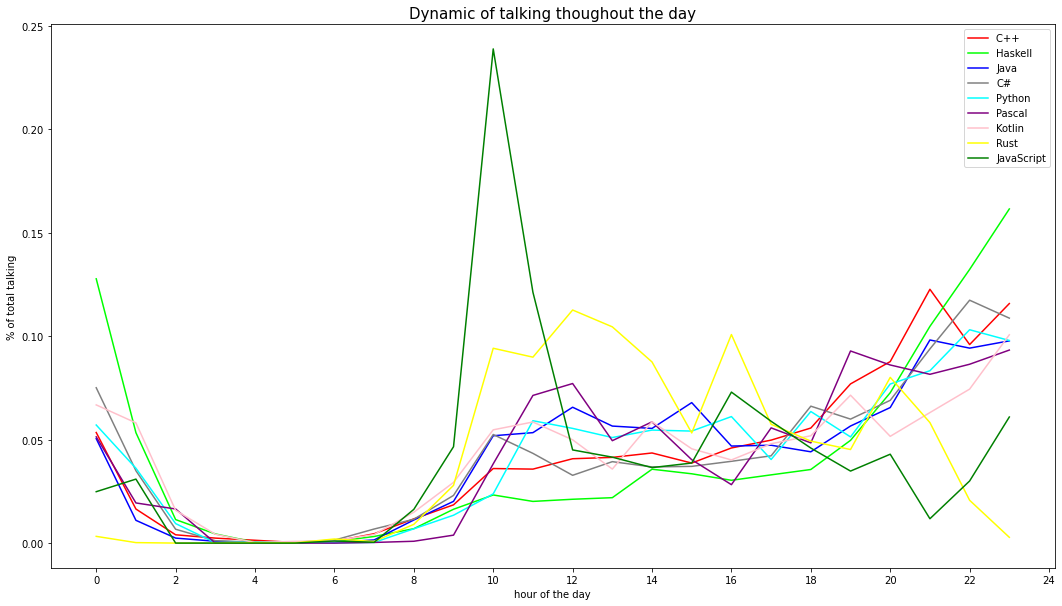

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
colors = ['red', 'lime','blue',  'grey', 'cyan', 'purple', 'pink', 'yellow', 'green', 'orange']
counter = 0;

for x in range (0, 9):
    dialog_id = df_top_10_people.loc[x, 'dialog_id']
    person = df_top_10_full[df_top_10_full['dialog_id'] == dialog_id].groupby('date').count().resample('H'
                                                                                                ).sum().reset_index()
    person['time'] = person['date'].dt.time
    grp_time_p = person[['message', 'time']].groupby('time').sum().reset_index()
    ax.plot(np.arange(0, 24), (grp_time_p['message'] / df_top_10_people.loc[x, 'messages']), color=colors[counter])
    counter += 1

plt.legend(df_top_10_people['name'])
plt.ylabel('% of total talking')
plt.xlabel('hour of the day')
plt.xticks(np.arange(0, 25, 2))
plt.title('Dynamic of talking thoughout the day', size=15)
plt.show()

Dynamic of talking with most people matches average dynamic. The only two people whose charts visibly differ are JavaScript with who I have english lessons at 10am with and my dad who I don't usually text at night

#### 
#### 22. Top-10 most used variations of my name

In [39]:
import re

def find_name(string): 
    words = re.split(r'\|\.|\..|…|,|;|:|#|!|\?|\¿|\n|\+| |\\|/|\)|\(|»', string)
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    
    return [re.sub(emoj, '', x) for x in words if (x.lower().startswith('нат') | x.lower().startswith('нот'))]

In [40]:
def normalize_name(name):
    if(name.endswith('е')):
        name = name[:-1]
    if(name[-1] in ['ш','к', 'т', 'х']):
        name += 'а'
    if(name.endswith('ь')):
        name = name.replace('ь', 'я')
    if(name.endswith('ю')):
        name = name.replace('ю', 'я')
    if(name.endswith('ика')):
        name = name[:-1]
    return name.lower()

In [41]:
names_full = [find_name(x) for x in df_prsnl['message'] if x != 0]
mistakes = ['нот', 'нотта', 'нота', 'ноты', 'ноті', 'нотер', 'нотебук', 'ноте', 'натурелла', 'натхнення']
names = [normalize_name(x[0]) for x in names_full if x]
names = [x for x in names if x not in mistakes]

df_names = pd.DataFrame(list(zip(names, [1]*len(names))), columns=['name_var', 'count']).groupby('name_var').count()
df_names.sort_values('count', ascending=False, inplace=True)

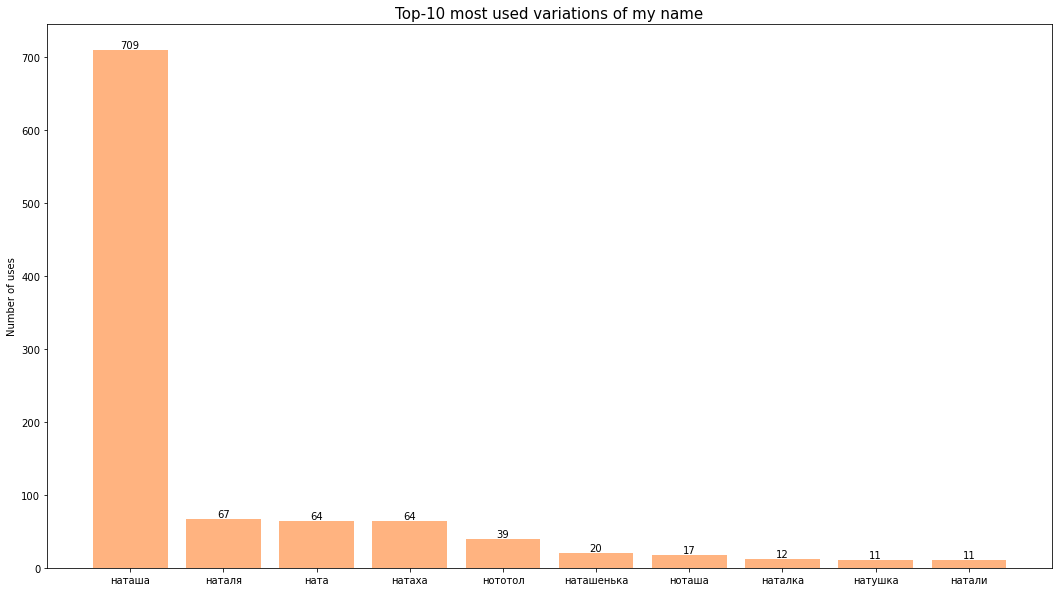

In [42]:
names_top_10 = df_names.head(10)

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
br = ax.bar(names_top_10.index, names_top_10['count'], color=(1, 0.7, 0.5))
plt.ylabel('Number of uses')
ax.bar_label(br)
plt.title('Top-10 most used variations of my name', size=15)
plt.show()

Such a huge gap between #1 and #2 can be explained by me being russian-speaking most of my life and in russian "наташа" is probably the only widely used variation of my name

#### 
#### 23. My personal favourite and funniest variations + who used them the most

In [43]:
def get_person(name):
    index_range = df_prsnl[df_prsnl['message'].str.lower().str.contains(name, na=False)].index
    df_name = df_prsnl.loc[index_range].groupby('name').count()
    df_name.sort_values('message', ascending=False, inplace=True)
    return df_name.reset_index().loc[0, 'name']

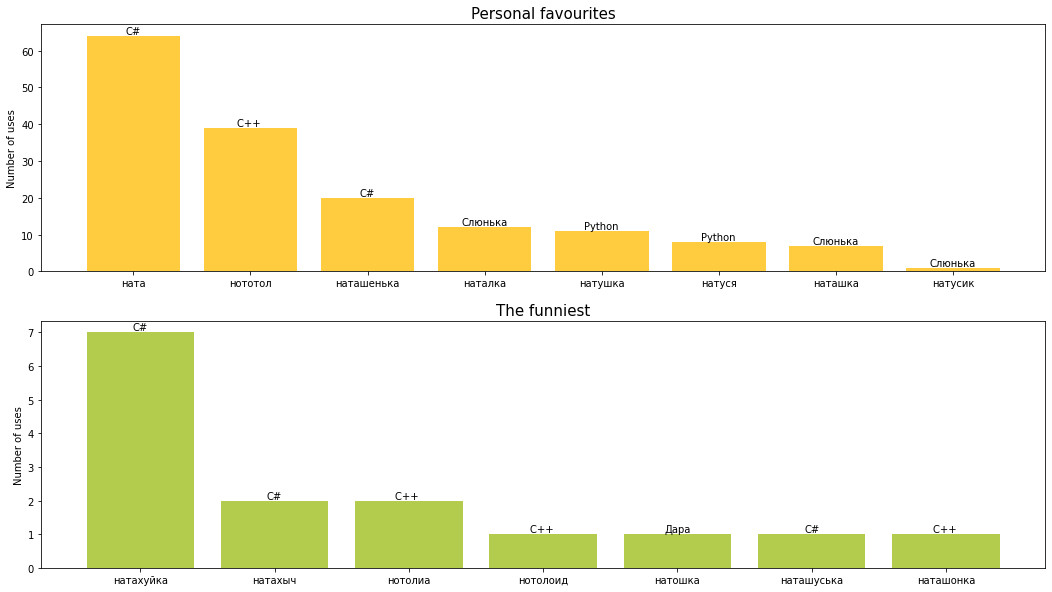

In [44]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(18, 10)

favourites = df_names.iloc[[2, 4, 5, 7, 8, 13, 14, 104]]
cursed = df_names.iloc[[19, 62, 63, 78, 166, 170, 174]]

people_f = [get_person(x) for x in favourites.index]
people_c = [get_person(x) for x in cursed.index]

br1 = ax[0].bar(favourites.index, favourites['count'], color=(1, 0.8, 0.25))
br2 = ax[1].bar(cursed.index, cursed['count'], color=(0.7, 0.8, 0.3))

ax[0].set_title('Personal favourites', size=15)
ax[0].bar_label(br1, people_f)
ax[1].set_title('The funniest', size=15)
ax[1].bar_label(br2, people_c)
ax[0].set_ylabel('Number of uses')
ax[1].set_ylabel('Number of uses')

plt.ylabel('Number of uses')
plt.show()

All of these were used by people that are either in top-10 or were once #1 in dialogs for the day. This means that the more you talk to people, the more creative they tend to get with names (or nicknames)

#### 
#### 24. Which forms of my name top-10 people use the most

In [45]:
top_variations = []
occurences = []

for x in df_top_10_people['dialog_id']:
    df = df_prsnl.loc[df_prsnl['dialog_id'] == x]
    names_p_full = [find_name(x) for x in df['message'] if x != 0]
    names_p = [normalize_name(x[0]) for x in names_p_full if x]
    names_p = [x for x in names_p if x not in mistakes]
    df_names_p = pd.DataFrame(list(zip(names_p, [1]*len(names_p))), columns=['name_var', 'count']).groupby('name_var'
                                                                                                            ).count()
    df_names_p.sort_values('count', ascending=False, inplace=True)
    top_variations.append(df_names_p.reset_index().loc[0, 'name_var'])
    occurences.append(df_names_p.reset_index().loc[0, 'count'])
    

In [46]:
for x in range (0, 9):
    print(df_top_10_people.reset_index().loc[x, 'name'],": ", top_variations[x], '-', occurences[x])

C++  :  нототол - 37
Haskell :  наташа - 5
Java :  наташа - 53
C# :  наташа - 152
Python :  ната - 45
Pascal :  наташа - 87
Kotlin :  ната - 14
Rust :  натали - 3
JavaScript :  натаха - 20


#### 
#### 25. Which people are in the same chats

This question uses an interactive chord diagram, but I couldn't manage to get it to show labels. So, to see the nickname of the person (node) you have to point cursor at it

In [47]:
df_meta['user_id'] = [df_meta.loc[x, 'users'][12:21] for x in df_meta.index]

def get_common_chats(id_1, id_2):
    if id_1 == id_2:
        return 0
    chats_1 = list(df_meta.loc[(df_meta['user_id'] == str(id_1)) & (df_meta['type'] == 'Group')]['dialog_id'])
    common_chats = [df_meta.loc[(df_meta['dialog_id'] == x) & (df_meta['user_id'] == str(id_2))]
                    .count()['dialog_id'] for x in chats_1] 
   
    return (len([x for x in common_chats if x != 0]))

source = []
target = []
value  = []

for i in df_top_10_people.index:
    for j in range(i, 10):
        source.append(df_top_10_people.loc[i, 'name'])
        target.append(df_top_10_people.loc[j, 'name'])
        value.append(get_common_chats(df_top_10_people.loc[i, 'dialog_id'],
                                          df_top_10_people.loc[j, 'dialog_id']))
        
        
commons = pd.DataFrame(list(zip(source, target, value)), columns=['source', 'target', 'value'])

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
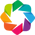

:Chord   [source,target]   (value)

In [48]:
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)

chord = hv.Chord(commons)
chord.opts(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(),
           title='Chord diagram on common chats of top-10 people in my telegram', node_color=dim('index').str())

Here the widest nodes(with the most common chats) have the people from my major in KMA because there's a lot of them in my top-10, so they're all interconnected. People from highschool have less total common chats because there're only 3 of them, but c++ and c# have the most common chats between them, than any other 2 people. The least chats has my friend from another faculty and my dad, who I have literally no common chats with.

#### 
#### 26. How many chats do top-10 people have in common with me and with each other

Here x axis shows the number of common chats with me, and the area of circle indicates with how many other people this person has common chats

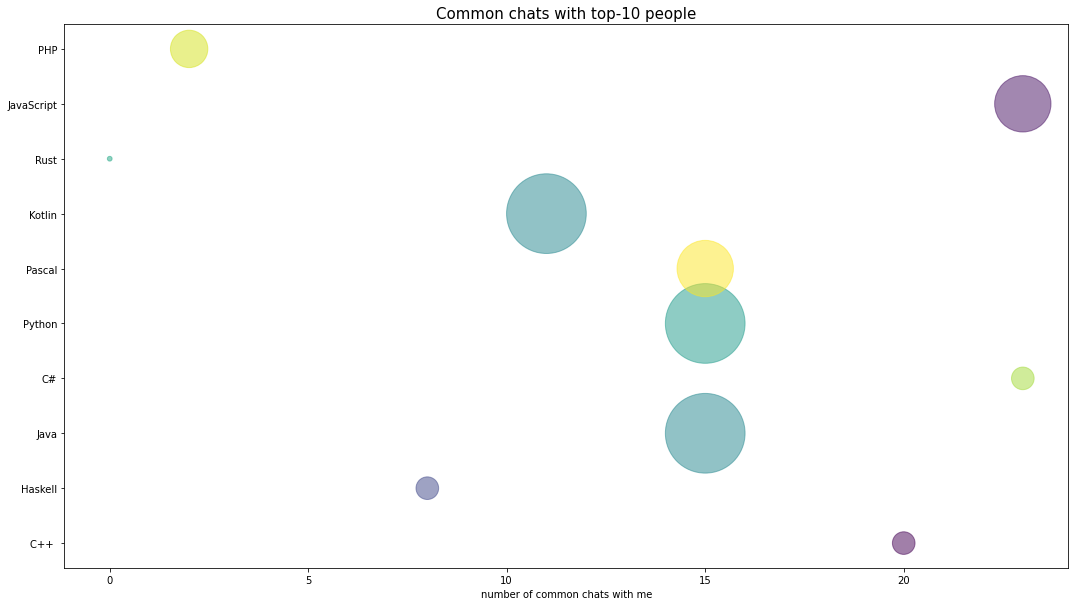

In [49]:
cmn_with_me = [df_meta.loc[(df_meta['user_id'] == str(x)) & (df_meta['type'] == 'Group')].
                                       count()['name'] for x in df_top_10_people['dialog_id']]
cmn_each_other = [(len([get_common_chats(x, y) for x in df_top_10_people['dialog_id'] if 
                       get_common_chats(x, y)!= 0])+ 2) ** 4.5 for y in df_top_10_people['dialog_id']]

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
colors = np.random.rand(10)

plt.scatter(cmn_with_me, df_top_10_people['name'], s=cmn_each_other, c=colors, alpha=0.5)
plt.title('Common chats with top-10 people', size=15)
plt.xlabel('number of common chats with me')
plt.show()

This chart differs from the last one. Unlike chord diagram, my friends from highschool (c++ and c#) have roughly the most chats with me. The rest of the results are similar. 